In [1]:
pip install torch torchvision matplotlib opencv-python-headless numpy pillow


  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.4 MB/s eta 0:00:00a 0:00:01
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import numpy as np

In [3]:
#  Load a pre-trained ResNet model from torchvision and set it to evaluation mode
model = models.resnet18(pretrained=True)
model.eval()

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),# Resize image to 224x224 pixels
    transforms.ToTensor(), # Convert image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# Normalize with mean and std
])


In [5]:
# Load and preprocess image
image_path = '/Users/atulrane/Documents/Project Echo/Project-Echo/src/Prototypes/engine/Cam_to_mel_ar/dog.png'
image = Image.open(image_path).convert('RGB') # Open and convert image to RGB
input_tensor = preprocess(image).unsqueeze(0) # Preprocess and add a batch dimension

In [6]:
# Save the features of the last convolutional layer for generating CAM
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.data.numpy() # Save the output features as a numpy array
    def remove(self):
        self.hook.remove()# Remove the hook when done

# Hook to the final convolutional layer of ResNet
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [7]:
# Perform a forward pass through the model to get the predictions
with torch.no_grad():
    output = model(input_tensor) # Get model output
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the predicted class index (the one with the highest probability)
pred_class = probabilities.argmax().item()
print(f'Predicted class: {pred_class}')
# Remove the hook after getting the features
activated_features.remove()

Predicted class: 207


In [8]:
# Function to calculate the CAM
def get_cam(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape  # Get dimensions of the feature map
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))  # Calculate weighted sum of features
    cam = cam.reshape(h, w)  # Reshape to original feature map size
    cam = cam - np.min(cam)  # Normalize CAM
    cam_img = cam / np.max(cam)
    return cam_img


In [9]:
# Get the predicted class index (the one with the highest probability)
pred_class = probabilities.argmax().item()
def get_cam(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

cam = get_cam(activated_features.features, weight_softmax, pred_class)

In [10]:
# Log raw CAM values
print('Raw CAM values:', cam)

Raw CAM values: [[0.         0.34933913 0.6769609  0.86948854 0.6240665  0.31945926
  0.0344928 ]
 [0.04734639 0.45934647 0.7913243  1.         0.7721646  0.42914683
  0.07885746]
 [0.09595767 0.45392123 0.82805914 0.9706102  0.82104707 0.4695822
  0.12802842]
 [0.08069503 0.27551907 0.56130254 0.623291   0.6007366  0.3166867
  0.09172856]
 [0.02464034 0.11873422 0.37148246 0.40100393 0.40888268 0.18791547
  0.03993908]
 [0.028431   0.12380798 0.34728244 0.3779894  0.3862972  0.18678318
  0.01838598]
 [0.00265173 0.05868386 0.21218225 0.26210883 0.27946228 0.13147646
  0.00403436]]


In [11]:
import cv2

mel_spectrogram_path = '/Users/atulrane/Documents/Project Echo/Project-Echo/src/Prototypes/engine/Cam_to_mel_ar/mel_spectrogram.png'
mel_spectrogram = cv2.imread(mel_spectrogram_path, cv2.IMREAD_GRAYSCALE)

# Ensure Mel spectrogram is a 3-channel image
if len(mel_spectrogram.shape) == 2:
    mel_spectrogram = cv2.cvtColor(mel_spectrogram, cv2.COLOR_GRAY2BGR)


In [19]:
# Resize CAM to match Mel spectrogram dimensions
input_height, input_width = mel_spectrogram.shape[:2]
cam_resized = cv2.resize(cam, (input_width, input_height))

# Apply heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

# Overlay CAM on Mel spectrogram
alpha = 0.5  # Transparency factor
overlayed_image = cv2.addWeighted(mel_spectrogram, alpha, heatmap, 1 - alpha, 0)


In [20]:
    # Draw bounding box
    # Threshold CAM to find the region with significant activations
    threshold = np.max(cam_resized) * 0.5  # Adjust threshold as needed
    mask = cam_resized > threshold
    y_indices, x_indices = np.where(mask)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

In [21]:
    # Draw a bounding box around the activated region
    cv2.rectangle(overlayed_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

array([[[192, 128, 128],
        [192, 128, 128],
        [192, 128, 128],
        ...,
        [208, 128, 128],
        [208, 128, 128],
        [208, 128, 128]],

       [[192, 128, 128],
        [192, 128, 128],
        [192, 128, 128],
        ...,
        [208, 128, 128],
        [208, 128, 128],
        [208, 128, 128]],

       [[192, 128, 128],
        [192, 128, 128],
        [192, 128, 128],
        ...,
        [208, 128, 128],
        [208, 128, 128],
        [208, 128, 128]],

       ...,

       [[192, 128, 128],
        [192, 128, 128],
        [192, 128, 128],
        ...,
        [194, 128, 128],
        [194, 128, 128],
        [194, 128, 128]],

       [[192, 128, 128],
        [192, 128, 128],
        [192, 128, 128],
        ...,
        [194, 128, 128],
        [194, 128, 128],
        [194, 128, 128]],

       [[192, 128, 128],
        [192, 128, 128],
        [192, 128, 128],
        ...,
        [194, 128, 128],
        [194, 128, 128],
        [194, 128, 128]]

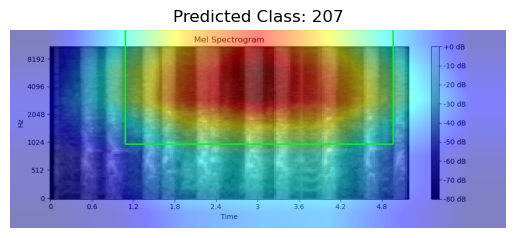

In [22]:
    plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted Class: {pred_class}')
    plt.axis('off')
    plt.show()

In [23]:
output_image_path = 'output_overlayed_image.png'
cv2.imwrite(output_image_path, overlayed_image)
print(f'Output image saved to {output_image_path}')

Output image saved to output_overlayed_image.png
